### Predicting Cluster Assignments in 2020

#### Overview
In continuation of our previous clustering work, we are now focusing on predicting the cluster assignments for the year 2020. This task is built upon the foundation of understanding and categorizing data into meaningful clusters. Our objective is to use historical data to predict which cluster a new data point (in this case, a year) would belong to.

#### Data Preparation
- **Training and Test Data**: We split our dataset into training and test sets based on the year. The training data includes all records up to the year 2018, ensuring that the model learns from the complete historical data. The test data comprises the records from 2019, allowing us to evaluate the model's predictive performance on unseen data.
- **Feature Selection**: We utilized various socio-economic and health indicators as features, including 'life_ladder', 'log_gdp_per_capita', 'social_support', 'healthy_life_exp_at_birth', and others. These features are crucial in reflecting the different dimensions that contribute to the well-being of a nation, which are pivotal in determining the cluster assignment.
- **Scaling**: Given the varying scales of the features, we applied standard scaling to normalize the data, ensuring that no single feature disproportionately influences the model's outcome.

#### Reference Data
- **Using Previous Cluster Assignments**: The cluster assignments from our prior clustering analysis are used as reference (target) data for the predictive models. These labels serve as the ground truth for training our models and evaluating their predictive accuracy.

#### Problem Definition
- **Multiclass Classification**: Our task is identified as a multiclass classification problem, where the goal is to classify each record into one of the pre-defined clusters based on the features.

#### Models and Evaluation
- **Random Forest**: Known for its robustness and effectiveness in handling tabular data. We evaluated its performance using metrics like accuracy and Cohen's Kappa.
- **SVC (Support Vector Classifier)**: We tested different kernels including linear, polynomial, and RBF to explore both linear and non-linear relationships in the data.
- **MLP (Multi-Layer Perceptron)**: A neural network model with two hidden layers was used to capture more complex patterns in the data.
- **Evaluation Metrics**: For each model, we computed accuracy and Cohen's Kappa to measure the model's predictive performance. Additionally, confusion matrices were examined to understand the model's behavior across different classes.

#### Conclusion
The experiment involved testing various models to identify the most suitable one for predicting cluster assignments based on socio-economic and health indicators. The use of different models and evaluation metrics provided a comprehensive understanding of each model's strengths and weaknesses in the context of our specific multiclass classification problem. Our models were trained against the backdrop of previously established cluster assignments, thereby grounding our predictive analysis in the context of our earlier clustering results.


#### Data Preparation

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('./data/prediction_data.csv')

# Rename the misspelled column
data = data.rename(columns={'social_suppoprt': 'social_support'})

# Filter data for training and testing, and explicitly create a copy
train_data = data[data['year'] <= 2019].copy()
test_data = data[data['year'] == 2020].copy()

# Define features and target
features = ['life_ladder', 'log_gdp_per_capita', 'social_support', 'healthy_life_exp_at_birth',
            'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption',
            'positive_affect', 'negative_affect', 'pop_density', 'suicide_rate']
target = 'cluster'

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])

y_train = train_data[target]
y_test = test_data[target]

# Print the size of train and test set
print(f"Size of Training Set: {X_train.shape[0]} samples")
print(f"Size of Test Set: {X_test.shape[0]} samples")

Size of Training Set: 1727 samples
Size of Test Set: 92 samples


#### Random Forest

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# Initialize and train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (Random Forest): {test_accuracy}")

# Compute and print Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa (Random Forest): {kappa}")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Random Forest):")
print(conf_matrix)



Test Accuracy (Random Forest): 0.9130434782608695
Cohen's Kappa (Random Forest): 0.8891900030111413
Confusion Matrix (Random Forest):
[[13  0  1  0  0]
 [ 0 10  0  1  0]
 [ 1  2 22  0  0]
 [ 0  2  0 23  0]
 [ 0  0  0  1 16]]


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],  # Number of trees
    'max_depth': [None, 10, 20, 30],   # Maximum depth of trees
    'max_features': ['sqrt', 'log2']   # Number of features for the best split
}

# Initialize the RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Use the best estimator for predictions
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

# Re-calculate test accuracy, confusion matrix and Cohen's kappa
test_accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy with Tuned Parameters: {test_accuracy}")
print(f"Cohen's Kappa: {kappa}")
print("Confusion Matrix with Tuned Parameters:")
print(conf_matrix)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
Test Accuracy with Tuned Parameters: 0.9021739130434783
Cohen's Kappa: 0.8756009615384616
Confusion Matrix with Tuned Parameters:
[[13  0  1  0  0]
 [ 0 11  0  0  0]
 [ 1  2 20  2  0]
 [ 0  2  0 23  0]
 [ 0  0  0  1 16]]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the best classifier
importances = best_classifier.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({
    'Feature': features,  # 'features' is the list of feature names
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances from Best RandomForest Model:")
print(feature_importances)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Best RandomForest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


NameError: name 'best_classifier' is not defined

#### SVC

Accuracy of Linear SVC: 0.9456521739130435
Cohen's Kappa for Linear SVC: 0.9303030303030303
Confusion Matrix for Linear SVC:
[[13  0  1  0  0]
 [ 0 11  0  0  0]
 [ 1  0 23  1  0]
 [ 0  0  1 24  0]
 [ 0  0  0  1 16]]

Feature Importances in Linear SVC (Percentage):
                         Feature  Importance (%)
1             log_gdp_per_capita       21.476746
3      healthy_life_exp_at_birth       16.680568
5                     generosity       14.634696
0                    life_ladder       14.301737
2                 social_support       10.821045
10                  suicide_rate        6.493035
6      perceptions_of_corruption        5.547982
4   freedom_to_make_life_choices        3.371788
7                positive_affect        3.218965
9                    pop_density        2.210848
8                negative_affect        1.242589


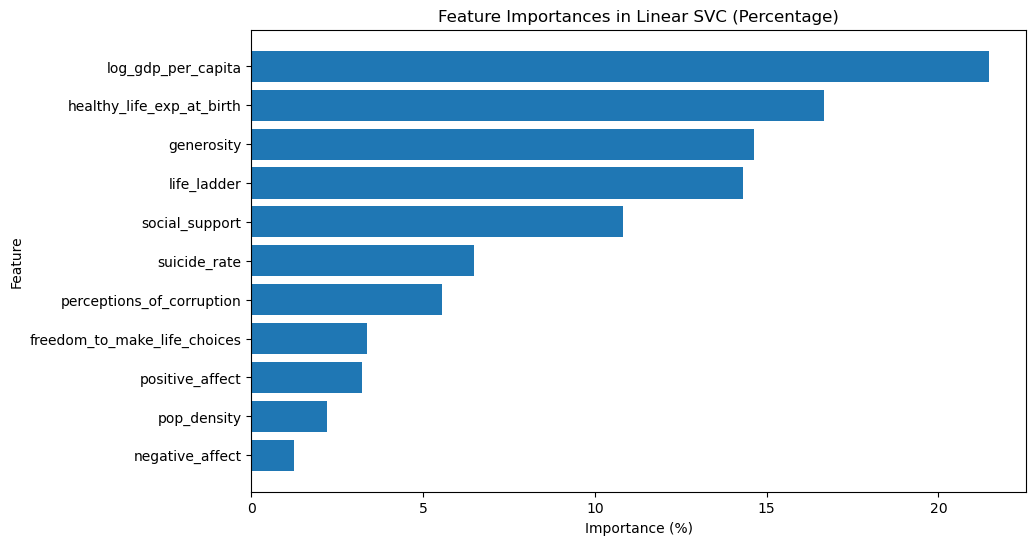

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the SVC model with a linear kernel
svc_linear = SVC(kernel='linear')

# Train the model
svc_linear.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = svc_linear.predict(X_test)

# Calculate and print the accuracy
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy of Linear SVC: {accuracy_linear}")

# Calculate and print Cohen's Kappa
kappa_linear = cohen_kappa_score(y_test, y_pred_linear)
print(f"Cohen's Kappa for Linear SVC: {kappa_linear}")

# Print the confusion matrix
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
print("Confusion Matrix for Linear SVC:")
print(conf_matrix_linear)

# Get the model coefficients and use absolute values
coefficients = abs(svc_linear.coef_[0])

# Normalizing the coefficients to sum to 1
coefficients_normalized = coefficients / coefficients.sum()

# Convert to percentage
coefficients_percentage = coefficients_normalized * 100

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance (%)': coefficients_percentage
})

# Sort the DataFrame by the percentage of importance
feature_importances = feature_importances.sort_values(by='Importance (%)', ascending=False)

# Display the feature importances
print("\nFeature Importances in Linear SVC (Percentage):")
print(feature_importances)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance (%)'])
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importances in Linear SVC (Percentage)')
plt.gca().invert_yaxis()
plt.show()


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# Initialize the SVC model
svc = SVC()

# Define the parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4]  # Degree for 'poly' kernel, ignored by others
}

# Create a GridSearchCV object
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_svc.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found for SVC:")
print(grid_search_svc.best_params_)

# Predict on the test set using the best parameters
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

# Evaluate the SVC model with tuned parameters
svc_accuracy = accuracy_score(y_test, y_pred_svc)
svc_kappa = cohen_kappa_score(y_test, y_pred_svc)
svc_conf_matrix = confusion_matrix(y_test, y_pred_svc)

print(f"SVC Test Accuracy with Tuned Parameters: {svc_accuracy}")
print(f"Cohen's Kappa for SVC: {svc_kappa}")
print("SVC Confusion Matrix with Tuned Parameters:")
print(svc_conf_matrix)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters Found for SVC:
{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVC Test Accuracy with Tuned Parameters: 0.9565217391304348
Cohen's Kappa for SVC: 0.9443099273607748
SVC Confusion Matrix with Tuned Parameters:
[[13  0  1  0  0]
 [ 0 11  0  0  0]
 [ 1  0 23  1  0]
 [ 0  0  1 24  0]
 [ 0  0  0  0 17]]


#### MLP

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the MLP Classifier with two hidden layers, each with 30 neurons
mlp = MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred_mlp = mlp.predict(X_test)

# Calculate and print the accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy of MLP with 2 Hidden Layers (30 Neurons Each): {accuracy_mlp}")

# Calculate and print Cohen's Kappa
kappa_mlp = cohen_kappa_score(y_test, y_pred_mlp)
print(f"Cohen's Kappa for MLP: {kappa_mlp}")

# Print the confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix for MLP:")
print(conf_matrix_mlp)

Accuracy of MLP with 2 Hidden Layers (30 Neurons Each): 0.9565217391304348
Cohen's Kappa for MLP: 0.9443099273607748
Confusion Matrix for MLP:
[[13  0  1  0  0]
 [ 0 11  0  0  0]
 [ 1  0 23  1  0]
 [ 0  0  1 24  0]
 [ 0  0  0  0 17]]


### Decision on Which Model to Use

#### Random Forest
- **Test Accuracy**: 0.9130
- **Cohen's Kappa**: 0.8892
- **Remarks**: Although Random Forest had the poorest results among the models, it offers simplicity and easy computation of feature importance scores. Tuning did not lead to significantly better results.
- **Feature Importances**:
    - log_gdp_per_capita: 21.63%
    - healthy_life_exp_at_birth: 13.47%
    - life_ladder: 13.37%
    - positive_affect: 9.04%
    - suicide_rate: 8.73%
    - social_support: 7.18%
    - generosity: 7.06%
    - freedom_to_make_life_choices: 6.64%
    - perceptions_of_corruption: 6.58%
    - pop_density: 3.48%
    - negative_affect: 2.81%

#### SVC (Support Vector Classifier)
- **Linear Kernel**:
    - **Accuracy**: 0.9457
    - **Cohen's Kappa**: 0.9303
    - **Feature Importances**:
        - log_gdp_per_capita: 21.48%
        - healthy_life_exp_at_birth: 16.68%
        - generosity: 14.63%
        - life_ladder: 14.30%
        - social_support: 10.82%
        - suicide_rate: 6.49%
        - perceptions_of_corruption: 5.55%
        - freedom_to_make_life_choices: 3.37%
        - positive_affect: 3.22%
        - pop_density: 2.21%
        - negative_affect: 1.24%
- **Tuned with RBF Kernel and C = 10**:
    - **Accuracy**: 0.9565
    - **Cohen's Kappa**: 0.9443

#### MLP (Multi-Layer Perceptron)
- **Accuracy**: 0.9565
- **Cohen's Kappa**: 0.9443
- **Remarks**: The MLP model achieved exactly the same accuracy as the tuned SVC model. It is a more complex model that can capture non-linear relationships in the data, but does not provide direct feature importance scores.

#### Conclusion
While the Random Forest model provides simplicity and easy interpretation through feature importance scores, both the tuned SVC and MLP models offer superior predictive performance. We will choose the SVC with a linear kernel as it provides a good balance between performance and interpretability due to its feature importance scores.


#### Combine new predictions with initial data set

In [8]:
import numpy as np

# Predict on the test set (assuming this has already been done)
# y_pred_linear = svc_linear.predict(X_test)

# Create a new column 'predicted_cluster' in the original 'data' DataFrame
# Initialize with NaN
data['predicted_cluster'] = np.nan

# Update 'predicted_cluster' for the year 2020 with the SVC predictions
data.loc[data['year'] == 2020, 'predicted_cluster'] = y_pred_linear

# Now, 'data' DataFrame will have the predictions for 2020 and NaN for other years


#### Save the data as csv file

In [12]:
# # Save the modified DataFrame to a CSV file
# data.to_csv('./data/result_data.csv', index=False)
data

,year,country,life_ladder,log_gdp_per_capita,social_support,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,PC1,PC2,PC3,cluster,predicted_cluster
0,2008.0,Afghanistan,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.600,3.964290,-1.623176,-0.491903,0,NaN
1,2009.0,Afghanistan,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.400,3.079301,-1.636933,-0.726216,0,NaN
2,2010.0,Afghanistan,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.300,2.960657,-1.490737,-0.423930,0,NaN
3,2011.0,Afghanistan,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.100,3.611757,-1.420968,-0.502139,0,NaN
4,2012.0,Afghanistan,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.000,3.214656,-1.977606,-0.652195,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016.0,Zimbabwe,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209,37.359969,16.800,1.429331,-0.007387,-1.866828,0,NaN
1815,2017.0,Zimbabwe,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224,38.131320,15.000,1.348954,-0.325163,-1.771706,0,NaN
1816,2018.0,Zimbabwe,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212,38.909614,14.000,1.617021,-0.027347,-1.605599,0,NaN
1817,2019.0,Zimbabwe,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235,39.691374,14.100,2.346806,0.169438,-1.497737,0,NaN


### Check, which countries actually changed clusters from 2019 to 2020 and were predicted correctly

In [13]:
# Check if any row has NaN in the 'cluster' column
nan_in_cluster = data['cluster'].isna().any()

if nan_in_cluster:
    print("There are NaN values in the 'cluster' column.")
else:
    print("There are no NaN values in the 'cluster' column.")



There are no NaN values in the 'cluster' column.


In [18]:
# Filter the data for 2019 and 2020
data_2019_2020 = data[data['year'].isin([2019, 2020])]

# Pivot the data to get one row per country with clusters for both years
pivoted_data = data_2019_2020.pivot(index='country', columns='year', values='cluster')

print(pivoted_data.shape)

# Assuming pivoted_data is already created as previously described
# Count the number of non-NaN values for 2020
non_nan_count_2020 = pivoted_data[2020].notna().sum()

print(f"Number of non-NaN values for 2020: {non_nan_count_2020}")

# Assuming pivoted_data has already been created with 2019 and 2020 cluster values

# Remove rows where the cluster value for 2020 is NaN
pivoted_data_clean = pivoted_data[pivoted_data[2020].notna()]
print(pivoted_data_clean.shape)

# Compare the clusters for each country between 2019 and 2020
pivoted_data_clean['changed'] = pivoted_data_clean[2019] != pivoted_data_clean[2020]

# Count the number of countries that changed clusters
num_changed = pivoted_data_clean['changed'].sum()

print(f"Number of countries that changed clusters from 2019 to 2020: {num_changed}")



(138, 2)
Number of non-NaN values for 2020: 92
(92, 2)
Number of countries that changed clusters from 2019 to 2020: 14


C:\Users\thali\AppData\Local\Temp\ipykernel_16172\4053089641.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivoted_data_clean['changed'] = pivoted_data_clean[2019] != pivoted_data_clean[2020]


In [19]:
# Filter the data for 2019 and 2020
data_2019_2020 = data[data['year'].isin([2019, 2020])]

# Pivot the data to get one row per country with clusters for both years
pivoted_data = data_2019_2020.pivot(index='country', columns='year', values='cluster')

# Add the predicted_cluster for 2020 to the pivoted data
pivoted_data['predicted_2020'] = data[data['year'] == 2020].set_index('country')['predicted_cluster']

# Remove rows where the cluster value for 2020 is NaN
pivoted_data = pivoted_data[pivoted_data[2020].notna()]

# Identify countries that changed clusters from 2019 to 2020
pivoted_data['changed_2019_to_2020'] = pivoted_data[2019] != pivoted_data[2020]

# Identify countries where the predicted cluster in 2020 changed from 2019
pivoted_data['predicted_change_2019_to_2020'] = pivoted_data[2019] != pivoted_data['predicted_2020']

# Print out the countries that changed clusters from 2019 to 2020
changed_countries = pivoted_data[pivoted_data['changed_2019_to_2020']].index.tolist()
print("Countries that changed clusters from 2019 to 2020:")
print(changed_countries)

# Print out the countries that were predicted to change clusters from 2019 to 2020
predicted_changed_countries = pivoted_data[pivoted_data['predicted_change_2019_to_2020']].index.tolist()
print("\nCountries predicted to change clusters from 2019 to 2020:")
print(predicted_changed_countries)


Countries that changed clusters from 2019 to 2020:
['Albania', 'Argentina', 'Chile', 'Croatia', 'Czech Republic', 'Estonia', 'Laos', 'Mongolia', 'Montenegro', 'Myanmar', 'Saudi Arabia', 'Serbia', 'Tanzania', 'Ukraine']

Countries predicted to change clusters from 2019 to 2020:
['Albania', 'Bosnia and Herzegovina', 'Chile', 'Croatia', 'Czech Republic', 'Mongolia', 'Montenegro', 'Myanmar', 'Saudi Arabia', 'Serbia', 'Ukraine']


In [21]:
# Calculate the number of entries that are different
actual_changes = pivoted_data['changed_2019_to_2020']
predicted_changes = pivoted_data['predicted_change_2019_to_2020']

# Count the number of mismatches
mismatches = (actual_changes != predicted_changes).sum()

print(f"Number of entries with different outcomes between actual and predicted changes: {mismatches}")


Number of entries with different outcomes between actual and predicted changes: 5


5

In [22]:
# Create a boolean series to identify mismatches between actual and predicted changes
mismatched_predictions = (pivoted_data['changed_2019_to_2020'] != pivoted_data['predicted_change_2019_to_2020'])

# Filter out the countries with mismatches
wrongly_predicted_countries = pivoted_data[mismatched_predictions].index.tolist()

print("Countries with wrongly predicted cluster changes from 2019 to 2020:")
print(wrongly_predicted_countries)


Countries with wrongly predicted cluster changes from 2019 to 2020:
['Argentina', 'Bosnia and Herzegovina', 'Estonia', 'Laos', 'Tanzania']
